## Import, load dataset, load saved model

In [1]:
import csv
import gzip
import os
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch

from scvi.dataset import GeneExpressionDataset, Dataset10X
from scvi.models import VAE, TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer, Posterior, UnsupervisedTrainer
from totalppc import TotalPosteriorPredictiveCheck as totalPPC

from scipy.special import softmax
from sklearn.decomposition import PCA
import umap

sns.set(context="notebook", font_scale=1.15, style="ticks")
save_path = "../data/10X"
%load_ext autoreload
%autoreload 2
%matplotlib inline

[2019-10-12 17:16:04,553] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.
/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/scikit_learn-0.19.2-py3.7-linux-x86_64.egg/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
dataset1 = Dataset10X(
    dataset_name="pbmc_10k_protein_v3",
    save_path=save_path,
    measurement_names_column=1,
    dense=True,
)
dataset2 = Dataset10X(
    dataset_name="5k_pbmc_protein_v3",
    save_path=save_path,
    measurement_names_column=1,
    dense=True,
)

[2019-10-12 17:53:39,223] INFO - scvi.dataset.dataset | File /data/yosef2/users/adamgayoso/projects/totalVI_reproducibility/data/10X/pbmc_10k_protein_v3/filtered_feature_bc_matrix.tar.gz already downloaded
[2019-10-12 17:53:39,225] INFO - scvi.dataset.dataset10X | Preprocessing dataset
[2019-10-12 17:54:13,677] INFO - scvi.dataset.dataset10X | Finished preprocessing dataset
[2019-10-12 17:54:15,621] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-10-12 17:54:15,623] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-10-12 17:54:16,037] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-10-12 17:54:16,449] INFO - scvi.dataset.dataset | Downsampled from 7865 to 7865 cells
[2019-10-12 17:54:16,514] INFO - scvi.dataset.dataset | File /data/yosef2/users/adamgayoso/projects/totalVI_reproducibility/data/10X/5k_pbmc_protein_v3/filtered_feature_bc_matrix.tar.gz already downloaded
[2019-10-12 17:54:16,515] INFO - scvi.dataset.dataset10

In [3]:
def filter_dataset(dataset):
    high_count_genes = (dataset.X > 0).sum(axis=0).ravel() > 0.01 * dataset.X.shape[0]
    dataset.update_genes(high_count_genes)
    dataset.subsample_genes(new_n_genes=5000)
    high_gene_count_cells = (dataset.X > 0).sum(axis=1).ravel() > 500
    dataset.update_cells(high_gene_count_cells)
    # Filter control proteins
    non_control_proteins = []
    for i, p in enumerate(dataset.protein_names):
        if not p.startswith("IgG"):
            non_control_proteins.append(i)
        else:
            print(p)
    dataset.protein_expression = dataset.protein_expression[:, non_control_proteins]
    dataset.protein_names = dataset.protein_names[non_control_proteins]
    high_protein_cells = dataset.protein_expression.sum(axis=1) >= np.percentile(dataset.protein_expression.sum(axis=1), 1)
    dataset.update_cells(high_protein_cells)
    return dataset

In [4]:
dataset1 = filter_dataset(dataset1)
dataset2 = filter_dataset(dataset2)

[2019-10-12 17:54:43,850] INFO - scvi.dataset.dataset | Downsampling from 33538 to 11272 genes
[2019-10-12 17:54:44,145] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-10-12 17:54:44,421] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2019-10-12 17:54:44,699] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-10-12 17:54:44,841] INFO - scvi.dataset.dataset | Downsampled from 7865 to 7865 cells
[2019-10-12 17:54:46,214] INFO - scvi.dataset.dataset | Downsampling from 11272 to 5000 genes
[2019-10-12 17:54:46,620] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-10-12 17:54:46,745] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2019-10-12 17:54:46,869] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-10-12 17:54:46,934] INFO - scvi.dataset.dataset | Downsampled from 7865 to 7865 cells
[2019-10-12 17:54:47,044] INFO - scvi.dataset.datas

IgG2a_control_TotalSeqB
IgG1_control_TotalSeqB
IgG2b_control_TotalSeqB


[2019-10-12 17:54:47,493] INFO - scvi.dataset.dataset | Downsampling from 33538 to 11667 genes
[2019-10-12 17:54:47,695] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-10-12 17:54:47,890] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2019-10-12 17:54:48,087] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-10-12 17:54:48,185] INFO - scvi.dataset.dataset | Downsampled from 5247 to 5247 cells
[2019-10-12 17:54:49,132] INFO - scvi.dataset.dataset | Downsampling from 11667 to 5000 genes
[2019-10-12 17:54:49,403] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-10-12 17:54:49,486] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2019-10-12 17:54:49,570] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-10-12 17:54:49,614] INFO - scvi.dataset.dataset | Downsampled from 5247 to 5247 cells
[2019-10-12 17:54:49,684] INFO - scvi.dataset.datas

IgG1_control_TotalSeqB
IgG2a_control_TotalSeqB
IgG2b_control_TotalSeqB


In [5]:
dataset = GeneExpressionDataset()
dataset.populate_from_datasets([dataset1, dataset2])

[2019-10-12 17:54:49,832] INFO - scvi.dataset.dataset | Keeping 4456 genes
[2019-10-12 17:54:49,913] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-10-12 17:54:50,007] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-10-12 17:54:50,010] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-10-12 17:54:50,178] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-10-12 17:54:50,243] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-10-12 17:54:50,245] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-10-12 17:54:50,551] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-10-12 17:54:50,553] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-10-12 17:54:50,557] INFO - scvi.dataset.dataset | Keeping 14 columns in protein_expression


In [6]:
totalvae = TOTALVI(dataset.nb_genes, len(dataset.protein_names), n_latent=20, n_batch=dataset.n_batches)
use_cuda = True
lr = 5e-3
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 150,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 30,
    "lr_factor": 0.6,
    "posterior_class": TotalPosterior,
}

trainer = TotalTrainer(
    totalvae,
    dataset,
    train_size=0.96,
    test_size=0.04,
    use_cuda=use_cuda,
    frequency=1,
    data_loader_kwargs={"batch_size":256},
    n_epochs_kl_warmup=200,
    n_epochs_back_kl_warmup=200,
    early_stopping_kwargs=early_stopping_kwargs,
    seed=3
)

In [7]:
trainer.train(lr=lr, n_epochs=500)

training:  67%|██████▋   | 336/500 [07:38<03:37,  1.33s/it]

[2019-10-12 18:02:54,644] INFO - scvi.inference.trainer | Reducing LR.
INFO:scvi.inference.trainer:Reducing LR.


training:  85%|████████▌ | 427/500 [09:36<01:33,  1.29s/it]

[2019-10-12 18:04:52,559] INFO - scvi.inference.trainer | Reducing LR.
INFO:scvi.inference.trainer:Reducing LR.


training:  94%|█████████▍| 471/500 [10:39<00:39,  1.34s/it]

[2019-10-12 18:05:54,825] INFO - scvi.inference.trainer | Reducing LR.
INFO:scvi.inference.trainer:Reducing LR.


training: 100%|██████████| 500/500 [11:16<00:00,  1.35s/it]


In [8]:
with torch.no_grad():
    print(trainer.test_set.compute_marginal_log_likelihood(n_samples_mc=100, batch_size=64))

3389.451847179089


In [9]:
with torch.no_grad():
    -trainer.test_set.compute_elbo(totalvae)

In [10]:
with torch.no_grad():
    print(trainer.test_set.compute_reconstruction_error(totalvae))

(3312.8957039337474, 63.556422263198755)


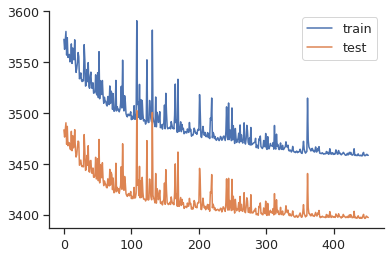

In [11]:
# plt.plot(trainer.history['elbo_validation_set'][50:], label="validation")
plt.plot(trainer.history['elbo_train_set'][50:], label="train")
plt.plot(trainer.history['elbo_test_set'][50:], label="test")
# plt.ylim(2500, 2600)
sns.despine()
plt.legend()

## Create posterior

In [12]:
full_posterior = trainer.create_posterior(totalvae, dataset, indices=np.arange(len(dataset)), type_class=TotalPosterior)
latent_mean, batch_index, label, library_gene = full_posterior.sequential().get_latent()
latent = full_posterior.sequential().get_latent(sample=True)[0]
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
N_SAMPLES = 50
parsed_protein_names = [p.split("_")[0] for p in dataset.protein_names]
py_mixing = sigmoid(full_posterior.sequential().get_sample_mixing(n_samples=N_SAMPLES, give_mean=True))
protein_pi = pd.DataFrame(data=py_mixing, columns=parsed_protein_names)
denoised_gene, denoised_pro = full_posterior.sequential().get_normalized_denoised_expression(n_samples=N_SAMPLES, give_mean=True)

In [13]:
torch.cuda.empty_cache()

In [14]:
umap_dr = umap.UMAP(n_neighbors=15, random_state=42, min_dist=0.1).fit_transform(latent_mean)

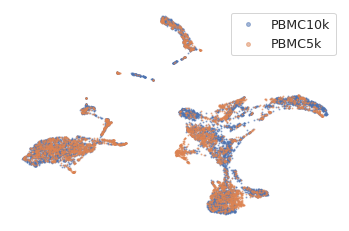

In [15]:
fig, ax = plt.subplots()
batches = dataset.batch_indices.ravel()
label = ["PBMC10k", "PBMC5k"]
for b in np.unique(dataset.batch_indices.ravel()):
    plt.scatter(umap_dr[batches == b, 0], umap_dr[batches == b, 1], label=label[b], s=1, alpha=0.5)
ax.axis("off")
legend = ax.legend()
legend.legendHandles[0]._sizes = [15]
legend.legendHandles[1]._sizes = [15]
# plt.savefig("harmonization.pdf")